In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [4]:
# Настройки отображения
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

# Пути к данным
BASE_DIR = Path.cwd()
GESTURE_DIR = BASE_DIR / 'Gesture'
TRAIN_DIR = GESTURE_DIR / 'train'
TEST_DIR = GESTURE_DIR / 'test'

print("Проверка наличия данных...")
print(f"Папка с данными: {GESTURE_DIR.exists()}")
print(f"Обучающая выборка: {TRAIN_DIR.exists()}")
print(f"Тестовая выборка: {TEST_DIR.exists()}")

# Параметры
IMG_SIZE = (64, 64)  # Размер изображения для обработки
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 20

Проверка наличия данных...
Папка с данными: True
Обучающая выборка: True
Тестовая выборка: True


In [ ]:
# Анализ данных
def analyze_dataset():
    """Анализ структуры и содержания датасета"""
    print("=" * 50)
    print("АНАЛИЗ ДАННЫХ")
    print("=" * 50)
    
    # Подсчет количества изображений
    train_counts = {}
    test_counts = {}
    
    for gesture_id in range(NUM_CLASSES):
        train_path = TRAIN_DIR / str(gesture_id)
        test_path = TEST_DIR / str(gesture_id)
        
        train_counts[gesture_id] = len(list(train_path.glob('*.jpg')))
        test_counts[gesture_id] = len(list(test_path.glob('*.jpg')))
    
    # Создание DataFrame для анализа
    df_analysis = pd.DataFrame({
        'Класс': list(train_counts.keys()),
        'Обучающие изображения': list(train_counts.values()),
        'Тестовые изображения': list(test_counts.values())
    })
    
    print("Количество изображений по классам:")
    print(df_analysis)
    
    # Визуализация распределения классов
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.bar(df_analysis['Класс'], df_analysis['Обучающие изображения'])
    ax1.set_title('Распределение обучающих изображений по классам')
    ax1.set_xlabel('Класс жеста')
    ax1.set_ylabel('Количество изображений')
    
    ax2.bar(df_analysis['Класс'], df_analysis['Тестовые изображения'])
    ax2.set_title('Распределение тестовых изображений по классам')
    ax2.set_xlabel('Класс жеста')
    ax2.set_ylabel('Количество изображений')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()
    
    
    return df_analysis

In [6]:
def show_sample_images():
    """Показать примеры изображений из каждого класса"""
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(NUM_CLASSES):
        class_dir = TRAIN_DIR / str(i)
        img_path = list(class_dir.glob('*.jpg'))[0]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Класс {i}')
        axes[i].axis('off')
    
    plt.suptitle('Примеры изображений жестов по классам', fontsize=16)
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

In [9]:
# Загрузка и предобработка данных
def load_and_preprocess_data():
    """Загрузка и предобработка изображений"""
    print("=" * 50)
    print("ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ")
    print("=" * 50)
    
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    # Загрузка обучающих данных
    for gesture_id in range(NUM_CLASSES):
        class_dir = TRAIN_DIR / str(gesture_id)
        for img_path in class_dir.glob('*.jpg'):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Нормализация
            
            X_train.append(img)
            y_train.append(gesture_id)
    
    # Загрузка тестовых данных
    for gesture_id in range(NUM_CLASSES):
        class_dir = TEST_DIR / str(gesture_id)
        for img_path in class_dir.glob('*.jpg'):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Нормализация
            
            X_test.append(img)
            y_test.append(gesture_id)
    
    # Преобразование в numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # One-hot encoding меток
    y_train_categorical = to_categorical(y_train, NUM_CLASSES)
    y_test_categorical = to_categorical(y_test, NUM_CLASSES)
    
    print(f"Размерность обучающих данных: {X_train.shape}")
    print(f"Размерность тестовых данных: {X_test.shape}")
    print(f"Метки обучающих данных: {y_train_categorical.shape}")
    print(f"Метки тестовых данных: {y_test_categorical.shape}")
    
    return X_train, X_test, y_train_categorical, y_test_categorical, y_train, y_test

In [ ]:
# Создание модели нейронной сети
def create_cnn_model():
    """Создание модели сверточной нейронной сети"""
    model = Sequential([
        # Первый сверточный блок
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Второй сверточный блок
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Третий сверточный блок
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Четвертый сверточный блок
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Полносвязные слои
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [11]:
# 4. Аугментация данных
def create_data_augmentation():
    """Создание генератора аугментированных данных"""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

In [12]:
# Обучение модели
def train_model(model, X_train, y_train, X_val, y_val):
    """Обучение модели с аугментацией данных"""
    datagen = create_data_augmentation()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    ]
    
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [13]:
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График точности
    ax1.plot(history.history['accuracy'], label='Обучающая точность')
    ax1.plot(history.history['val_accuracy'], label='Валидационная точность')
    ax1.set_title('Точность модели')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax1.grid(True)
    
    # График потерь
    ax2.plot(history.history['loss'], label='Обучающие потери')
    ax2.plot(history.history['val_loss'], label='Валидационные потери')
    ax2.set_title('Потери модели')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Потери')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [14]:
# Оценка модели и визуализация результатов
def evaluate_model(model, X_test, y_test, y_test_original):
    """Оценка модели и создание отчетов"""
    print("=" * 50)
    print("ОЦЕНКА МОДЕЛИ")
    print("=" * 50)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Метрики
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Тестовая точность: {test_accuracy:.4f}")
    print(f"Тестовые потери: {test_loss:.4f}")
    
    # Отчет классификации
    print("\nОтчет классификации:")
    print(classification_report(y_test_original, y_pred_classes))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test_original, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(NUM_CLASSES), 
                yticklabels=range(NUM_CLASSES))
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return test_accuracy, test_loss

АНАЛИЗ ДАННЫХ
Количество изображений по классам:
    Класс  Обучающие изображения  Тестовые изображения
0       0                    900                   300
1       1                    900                   300
2       2                    900                   300
3       3                    900                   300
4       4                    900                   300
5       5                    900                   300
6       6                    900                   300
7       7                    900                   300
8       8                    900                   300
9       9                    900                   300
10     10                    900                   300
11     11                    900                   300
12     12                    900                   300
13     13                    900                   300
14     14                    900                   300
15     15                    900                   300
16     16       

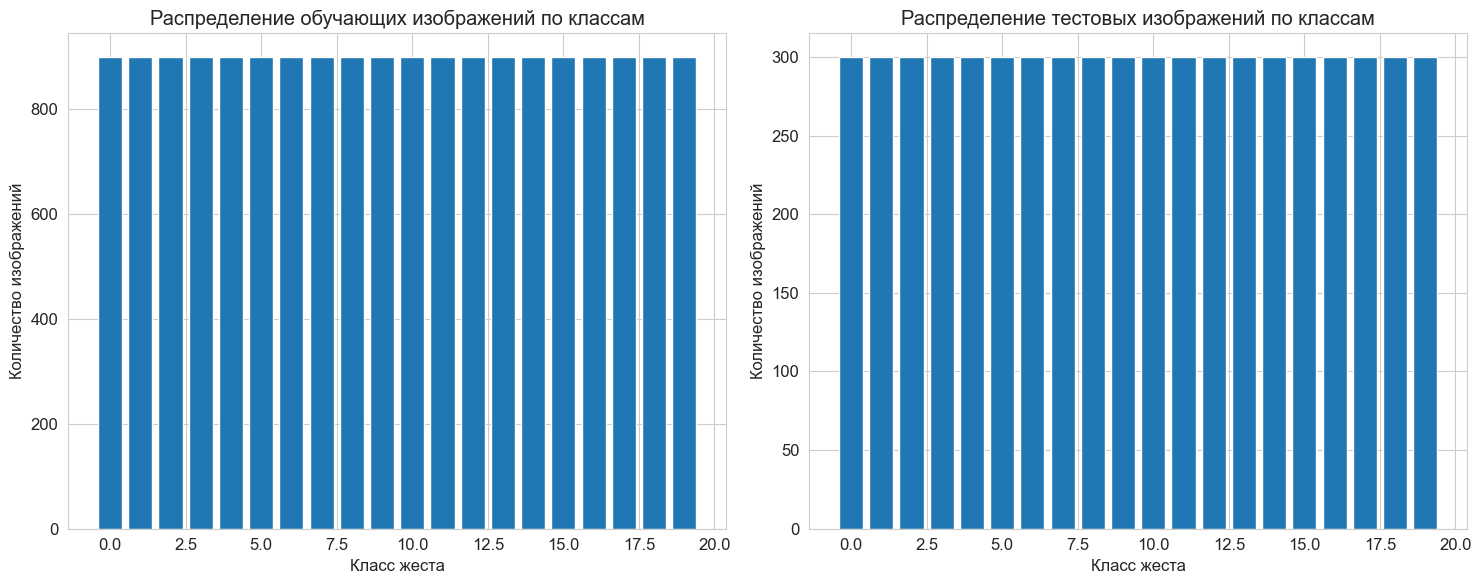

ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ
Размерность обучающих данных: (18000, 64, 64, 3)
Размерность тестовых данных: (6000, 64, 64, 3)
Метки обучающих данных: (18000, 20)
Метки тестовых данных: (6000, 20)
Архитектура модели:


c:\Users\anmrt\Desktop\practice_6sem_retake\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,054,676 (4.02 MB)

 Trainable params: 1,052,180 (4.01 MB)

 Non-trainable params: 2,496 (9.75 KB)

Начало обучения...


c:\Users\anmrt\Desktop\practice_6sem_retake\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3308 - loss: 2.2413 - val_accuracy: 0.1008 - val_loss: 5.9457 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.6153 - loss: 1.0807 - val_accuracy: 0.9544 - val_loss: 0.1824 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7515 - loss: 0.7120 - val_accuracy: 0.9214 - val_loss: 0.2087 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8128 - loss: 0.5223 - val_accuracy: 0.9756 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8602 - loss: 0.4046 - val_accuracy: 0.9783 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8840 - loss: 0.3376 - val_accuracy: 0.9417 - val_loss: 0.1599 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8983 - l

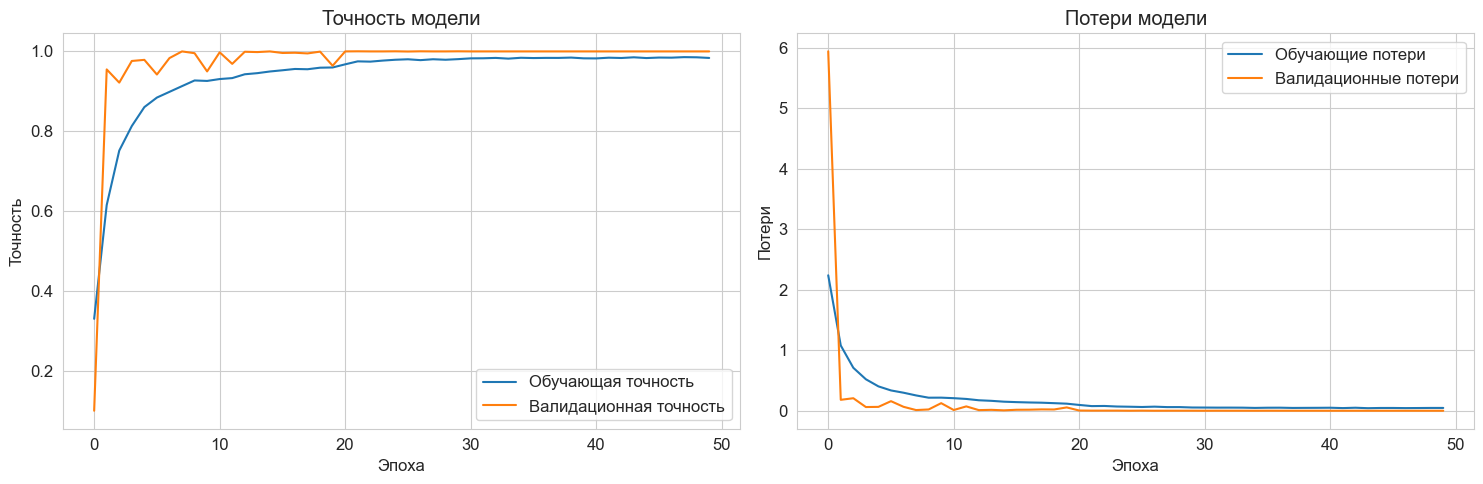

ОЦЕНКА МОДЕЛИ
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Тестовая точность: 1.0000
Тестовые потери: 0.0004

Отчет классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300
          12       1.00      1.00      1.00       300
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       300
       

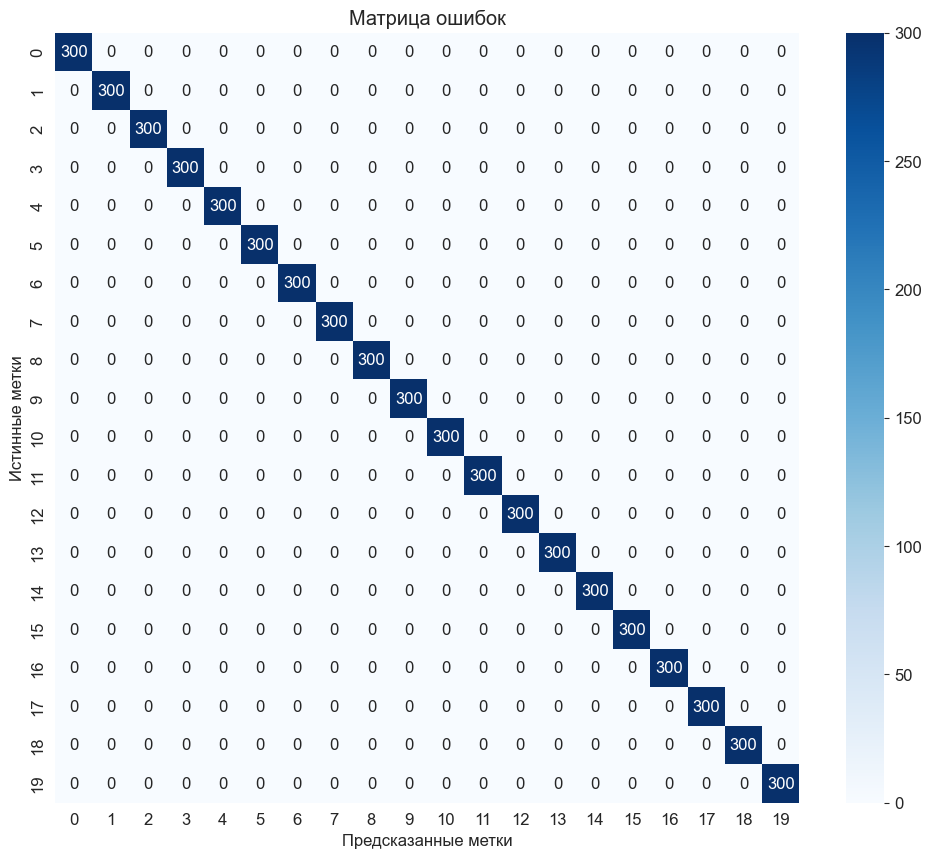

Модель сохранена как 'gesture_recognition_model.h5'


In [20]:
def main():
    df_analysis = analyze_dataset()
    
    X_train, X_test, y_train, y_test, y_train_orig, y_test_orig = load_and_preprocess_data()
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train_orig
    )
    
    model = create_cnn_model()
    print("Архитектура модели:")
    model.summary()
    
    print("Начало обучения...")
    history = train_model(model, X_train, y_train, X_val, y_val)
    
    plot_training_history(history)
    
    test_accuracy, test_loss = evaluate_model(model, X_test, y_test, y_test_orig)
    
    # Сохранение модели
    model.save('gesture_recognition_model.h5')
    print("Модель сохранена как 'gesture_recognition_model.h5'")

if __name__ == "__main__":
    main()